In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

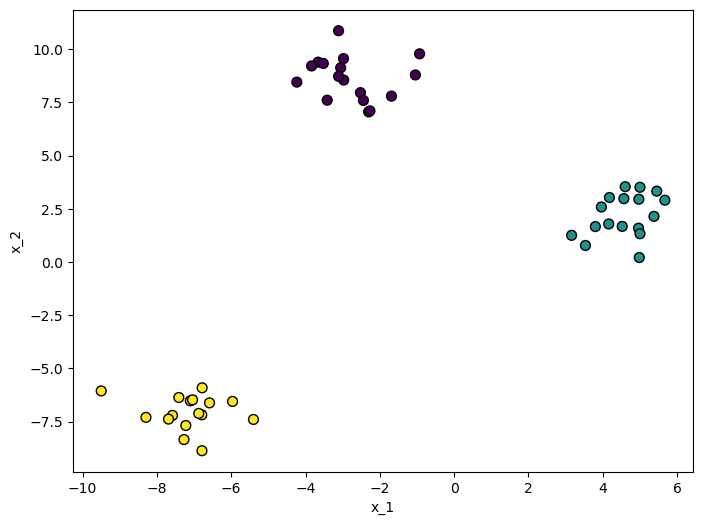

In [3]:
# 데이터 생성
X, y = make_blobs(n_samples=50, centers=3, random_state=42, cluster_std=1.0)

# 데이터 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

In [4]:
class SVM:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None  # 가중치 벡터
        self.bias = None  # 절편

    def fit(self, X, y):
        """
        SVM 모델 학습
        - X: 입력 데이터 (data 개수 x feature 개수)
        - y: 타겟 레이블 (data 개수만큼 -1 또는 1로 이루어진 배열)
        """
        n_samples, n_features = X.shape # n_samples: 데이터 개수

        # 레이블을 -1 또는 1로 변환
        y_modified = np.where(y <= 0, -1, 1)

        # Weight 및 bias 초기화
        self.weights = np.zeros(n_features)  # 가중치 벡터
        self.bias = 0  # 절편

        # 경사 하강법(Gradient Descent) 구현
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                # 조건: y_i(W^T * x_i + b) >= 1 (마진 조건 확인)
                condition = y_modified[idx] * (np.dot(x_i, self.weights) + self.bias) >= 1

                if not condition:  # 마진 조건을 만족하지 않는 경우
                    # 힌지 손실 함수의 그래디언트를 계산하여 가중치 업데이트
                    # ∂L/∂W = y_i * x_i 에 따라 가중치 업데이트
                    self.weights += self.learning_rate * (y_modified[idx] * x_i)
                    # ∂L/∂b = y_i 에 따라 바이어스 업데이트
                    self.bias += self.learning_rate * (y_modified[idx])

    def predict(self, X):
        """
        새로운 데이터에 대한 클래스 예측
        - X: 입력 데이터
        - 반환값: 예측된 클래스 레이블 (-1 또는 1)
        """
        # 결정 함수: w^T * x + b
        linear_output = np.dot(X, self.weights) + self.bias
        # sign 함수로 -1 또는 1로 변환
        return np.sign(linear_output)

In [5]:
class MultiSVM:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.classifiers = {}  # 각 클래스 쌍별 SVM 분류기 저장

    def fit(self, X, y):
        """
        One-vs-One 방식으로 다중 클래스 SVM 모델 학습
        - X: 입력 데이터 (data 개수 x feature 개수)
        - y: 타겟 레이블 (data 개수만큼의 클래스 레이블)
        """
        self.classes = np.unique(y)  # 고유한 클래스 레이블 추출
        n_classes = len(self.classes)
        
        # 모든 클래스 쌍에 대해 One-vs-One 방식으로 SVM 학습
        for i in range(n_classes):
            for j in range(i+1, n_classes):
                # 현재 클래스 쌍에 해당하는 데이터만 선택
                mask = np.logical_or(y == self.classes[i], y == self.classes[j])
                X_subset = X[mask]
                y_subset = y[mask]
                
                # i번째 클래스를 1, j번째 클래스를 -1로 변환
                y_binary = np.where(y_subset == self.classes[i], 1, -1)
                
                # 해당 클래스 쌍에 대한 SVM 분류기 생성 및 학습
                svm = SVM(learning_rate=self.learning_rate, n_iters=self.n_iters)
                svm.fit(X_subset, y_binary)
                
                # 학습된 분류기 저장
                self.classifiers[(self.classes[i], self.classes[j])] = svm
    
    def predict(self, X):
        """
        새로운 데이터에 대한 클래스 예측 (One-vs-One 투표 방식)
        - X: 입력 데이터
        - 반환값: 예측된 클래스 레이블
        """
        # 각 클래스에 대한 투표를 저장할 배열
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # 모든 이진 분류기에 대해 예측 및 투표
        for (class_i, class_j), svm in self.classifiers.items():
            # 분류기로 예측
            predictions = svm.predict(X)
            
            # 투표 누적: 1이면 class_i에 투표, -1이면 class_j에 투표
            for k in range(n_samples):
                if predictions[k] == 1:
                    votes[k, np.where(self.classes == class_i)[0][0]] += 1
                else:
                    votes[k, np.where(self.classes == class_j)[0][0]] += 1
        
        # 가장 많은 투표를 받은 클래스 선택
        return self.classes[np.argmax(votes, axis=1)]

In [6]:
# 모델 생성 및 학습
model = MultiSVM(learning_rate=0.01, n_iters=1000)
model.fit(X, y)

# 예측
y_pred = model.predict(X)

# 정확도 계산
accuracy = np.sum(y_pred == y) / len(y)
print(f"정확도: {accuracy:.4f}")

정확도: 1.0000


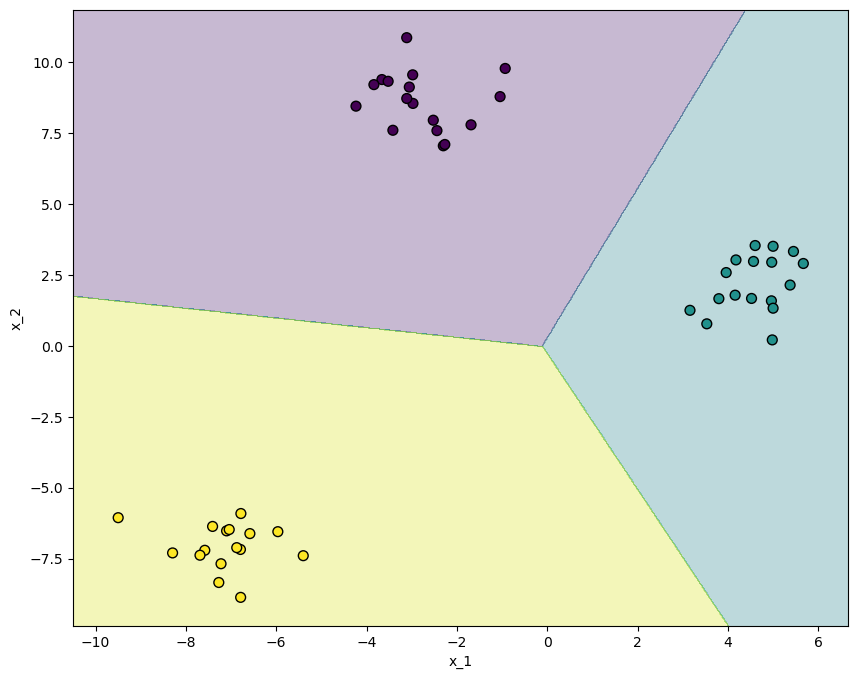

In [8]:
# 결정 경계 시각화
def plot_decision_boundary(model, X, y):
    """
    One-vs-One MultiSVM의 결정 경계 시각화
    """
    h = 0.02  # 격자의 스텝 크기
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 격자 포인트에 대한 예측
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 결정 경계 시각화
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # 원본 데이터 포인트 시각화
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.show()

# 시각화 호출
plot_decision_boundary(model, X, y)

In [9]:
# 각 이진 분류기의 정보 출력
for (class_i, class_j), svm in model.classifiers.items():
    print(f"클래스 {class_i} vs 클래스 {class_j}:")
    print(f"  가중치 (w): {svm.weights}")
    print(f"  편향 (b): {svm.bias}")
    
    # 마진 계산
    margin = 2 / np.sqrt(np.sum(svm.weights ** 2))
    print(f"  마진 크기: {margin:.4f}")
    print("-" * 50)

클래스 0 vs 클래스 1:
  가중치 (w): [-0.37635854  0.14290836]
  편향 (b): -0.04
  마진 크기: 4.9680
--------------------------------------------------
클래스 0 vs 클래스 2:
  가중치 (w): [0.04088134 0.23979387]
  편향 (b): 0.01
  마진 크기: 8.2219
--------------------------------------------------
클래스 1 vs 클래스 2:
  가중치 (w): [0.26848648 0.11203075]
  편향 (b): 0.03
  마진 크기: 6.8747
--------------------------------------------------


C:\Users\엄윤상\AppData\Local\Temp\ipykernel_11720\236101886.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


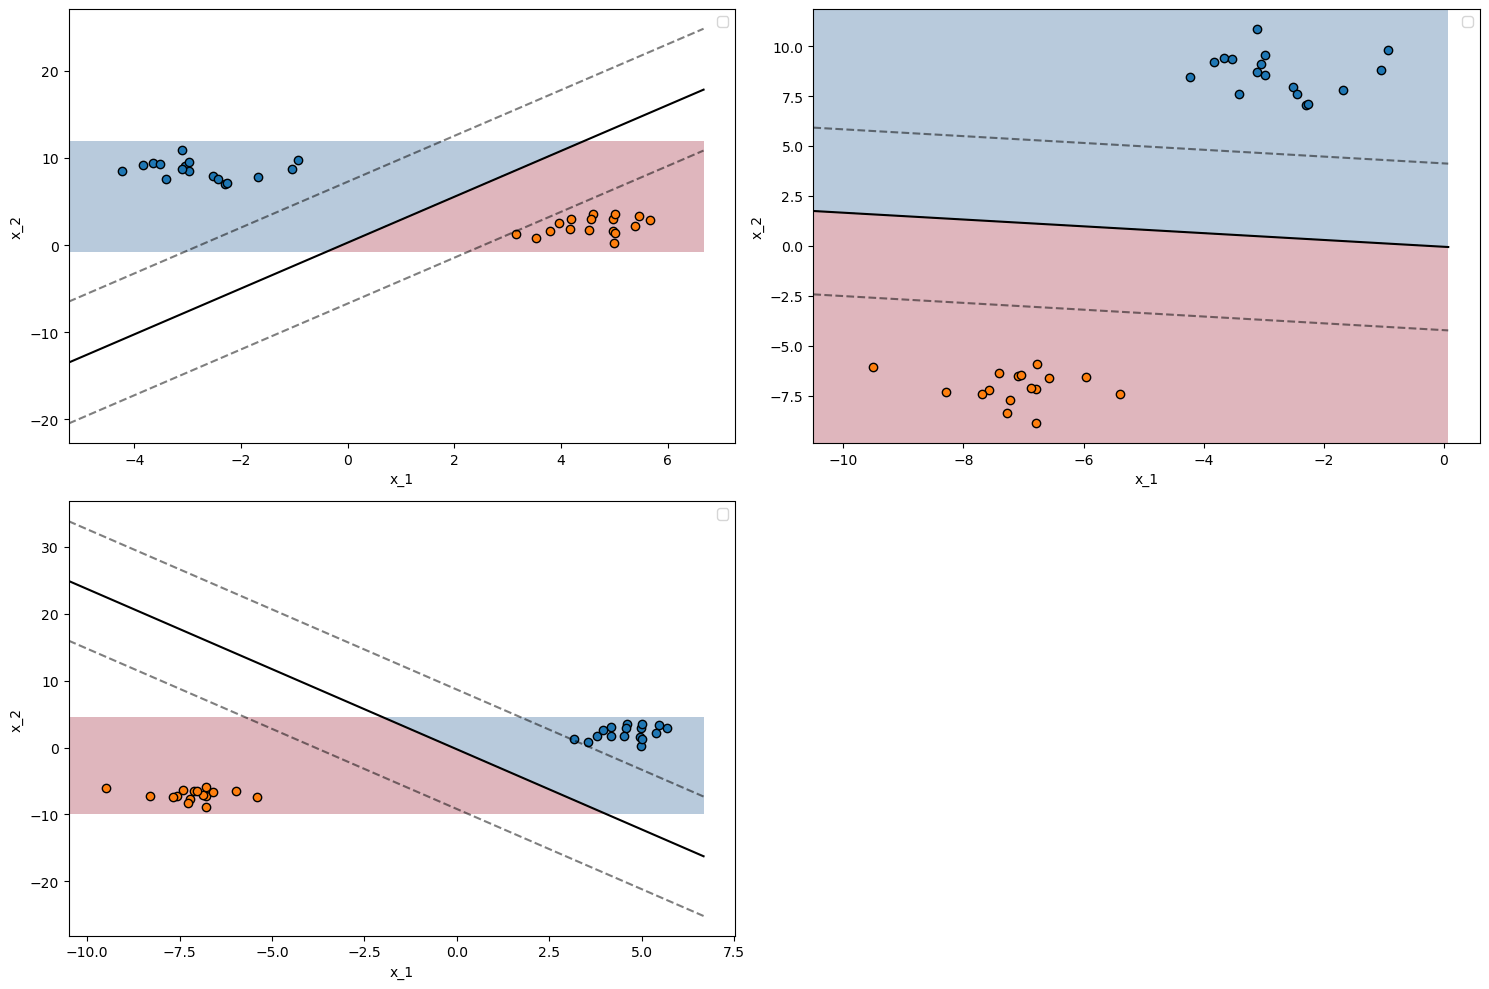

In [12]:
# 개별 클래스 쌍에 대한 결정 경계 시각화
def plot_binary_decision_boundaries(model, X, y):
    """
    각 이진 분류기의 결정 경계 시각화
    """
    n_classifiers = len(model.classifiers)
    n_cols = 2
    n_rows = (n_classifiers + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, ((class_i, class_j), svm) in enumerate(model.classifiers.items()):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 현재 클래스 쌍에 해당하는 데이터만 선택
        mask = np.logical_or(y == class_i, y == class_j)
        X_subset = X[mask]
        y_subset = y[mask]
        
        # 결정 경계 그리기 위한 격자 생성
        h = 0.02
        x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
        y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        # 격자 포인트에 대한 예측
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # 결정 경계 시각화
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
        
        # 해당 클래스의 데이터 포인트 시각화
        for c in [class_i, class_j]:
            plt.scatter(X_subset[y_subset == c, 0], X_subset[y_subset == c, 1], 
                        edgecolors='k')
        
        # 가중치 벡터 시각화
        if np.sum(svm.weights ** 2) > 0:  # 가중치가 0이 아닌 경우에만
            scale = 1.0
            w = svm.weights
            b = svm.bias
            
            # 결정 경계: w[0]*x + w[1]*y + b = 0
            # => y = (-w[0]*x - b) / w[1]
            xx_line = np.linspace(x_min, x_max)
            yy_line = (-w[0] * xx_line - b) / w[1]
            
            # 결정 경계 선 그리기
            plt.plot(xx_line, yy_line, 'k-')
            
            # 마진 경계선 그리기
            plt.plot(xx_line, (-w[0] * xx_line - b + 1) / w[1], 'k--', alpha=0.5)
            plt.plot(xx_line, (-w[0] * xx_line - b - 1) / w[1], 'k--', alpha=0.5)
        
        plt.xlabel('x_1')
        plt.ylabel('x_2')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 개별 이진 분류기의 결정 경계 시각화
plot_binary_decision_boundaries(model, X, y)